<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/nn_baseline_with_eda_and_predict_80_pressures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [3]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle

In [4]:
!kaggle competitions download -c ventilator-pressure-prediction

  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.4MB/s]
 95% 72.0M/75.4M [00:00<00:00, 177MB/s]
100% 75.4M/75.4M [00:00<00:00, 170MB/s]
 85% 118M/139M [00:00<00:00, 192MB/s] 
100% 139M/139M [00:00<00:00, 204MB/s]


In [5]:
!mkdir -p /kaggle/input/ventilator-pressure-prediction
!unzip '*.zip' -d /kaggle/input/ventilator-pressure-prediction
!ls /kaggle/input/ventilator-pressure-prediction

Archive:  sample_submission.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/sample_submission.csv  

Archive:  test.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/test.csv  

Archive:  train.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/train.csv  

3 archives were successfully processed.
sample_submission.csv  test.csv  train.csv


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/test.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/sample_submission.csv


In [7]:
BASE_FOLD = '/kaggle/input/ventilator-pressure-prediction/'
DEBUG = False

In [8]:
train = pd.read_csv(BASE_FOLD + 'train.csv', index_col='id')
test = pd.read_csv(BASE_FOLD + 'test.csv', index_col='id')
train.shape,test.shape

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


((6036000, 7), (4024000, 6))

In [9]:
if DEBUG:
    train = train[:80*1000]

# Train/Test data is batched by 80

In [10]:
train.breath_id.nunique(), train.breath_id.nunique()*80

(75450, 6036000)

In [11]:
test.breath_id.nunique(), test.breath_id.nunique()*80

(50300, 4024000)

# Train data has similar mean/std

In [12]:
train.describe()

,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [13]:
test.describe()

,breath_id,R,C,time_step,u_in,u_out
count,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06
mean,6.292796e+04,2.710785e+01,2.607038e+01,1.307083e+00,7.338098e+00,6.203864e-01
std,3.624924e+04,1.954281e+01,1.717103e+01,7.658902e-01,1.350955e+01,4.852908e-01
min,0.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.153050e+04,5.000000e+00,1.000000e+01,6.428454e-01,4.096735e-01,0.000000e+00
50%,6.305750e+04,2.000000e+01,2.000000e+01,1.308083e+00,4.377512e+00,1.000000e+00
75%,9.433325e+04,5.000000e+01,5.000000e+01,1.965240e+00,4.983472e+00,1.000000e+00
max,1.257480e+05,5.000000e+01,5.000000e+01,2.935203e+00,1.000000e+02,1.000000e+00


In [14]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

#sklearn
from sklearn.preprocessing import minmax_scale

# Check each batch

In [15]:
df_full = train[['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']]
df_full = pd.DataFrame(minmax_scale(df_full), columns=['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'])
df = df_full.iloc[:80,:]
df.describe()

,R,C,time_step,u_in,u_out,pressure
count,8.000000e+01,80.0,80.000000,80.000000,80.000000,80.000000
mean,3.333333e-01,1.0,0.457779,0.101460,0.625000,0.190911
std,3.910297e-16,0.0,0.269411,0.101237,0.487177,0.076968
min,3.333333e-01,1.0,0.000000,0.000000,0.000000,0.115911
25%,3.333333e-01,1.0,0.228666,0.027644,0.000000,0.130664
50%,3.333333e-01,1.0,0.457790,0.049226,1.000000,0.142255
75%,3.333333e-01,1.0,0.686566,0.203772,1.000000,0.283983
max,3.333333e-01,1.0,0.915747,0.283130,1.000000,0.321391


R


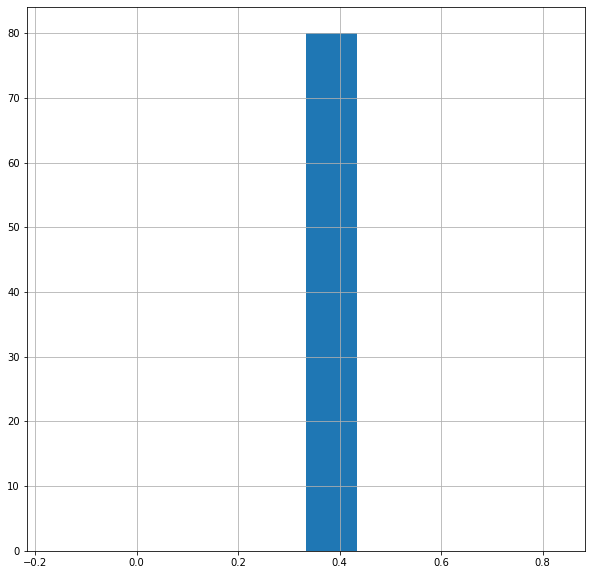

C


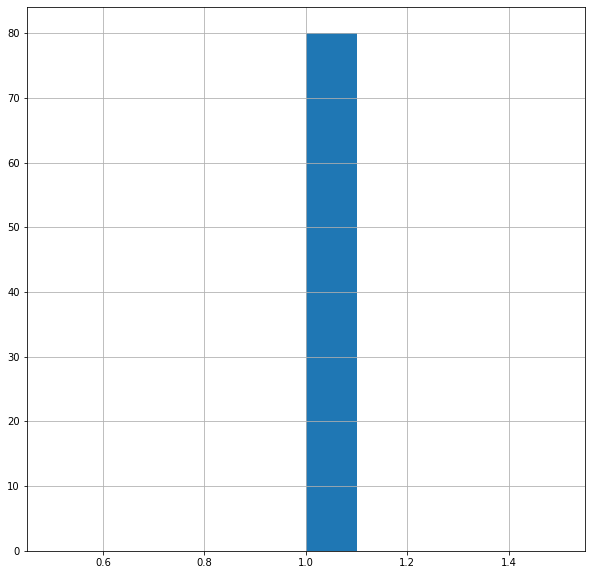

time_step


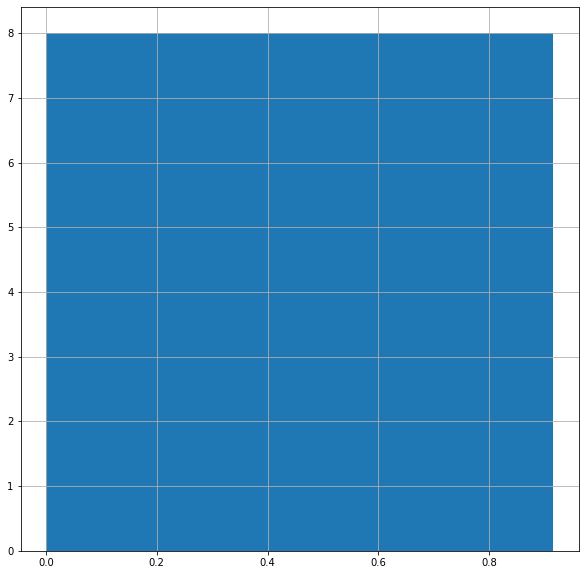

u_in


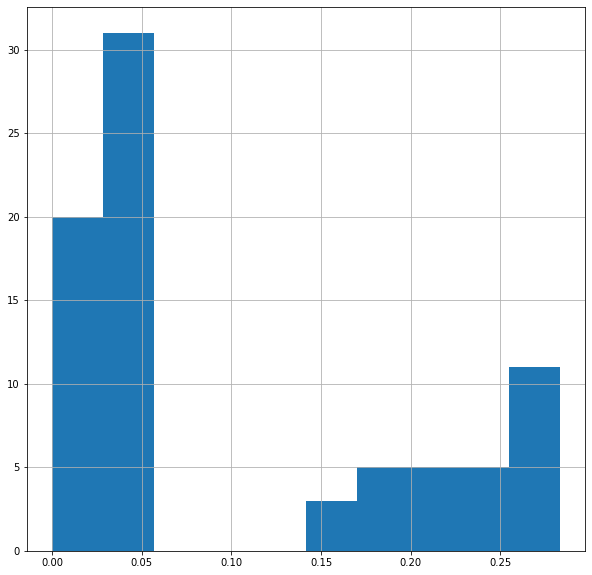

u_out


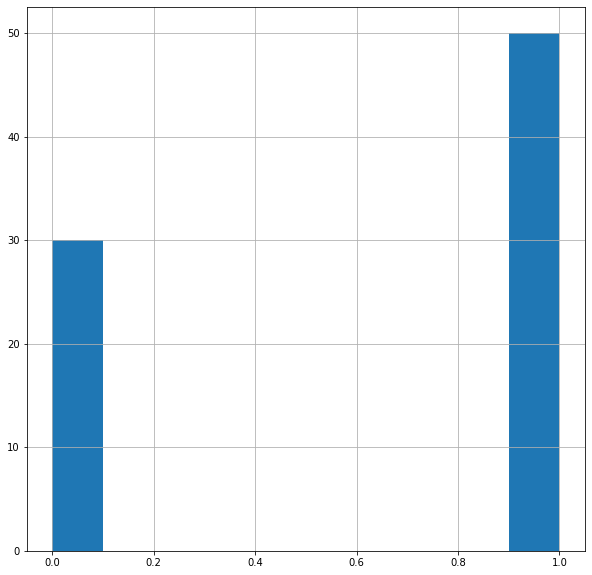

pressure


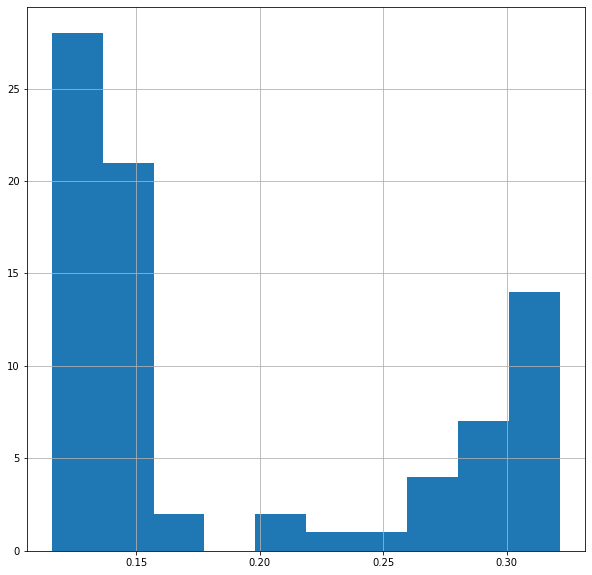

In [16]:
for col in df.columns:
    print(col)
    df[col].hist()
    plt.show()


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.33333333333333337 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.33333333333333337 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.33333333333333337 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7062999fd0>,
      dtype=object)

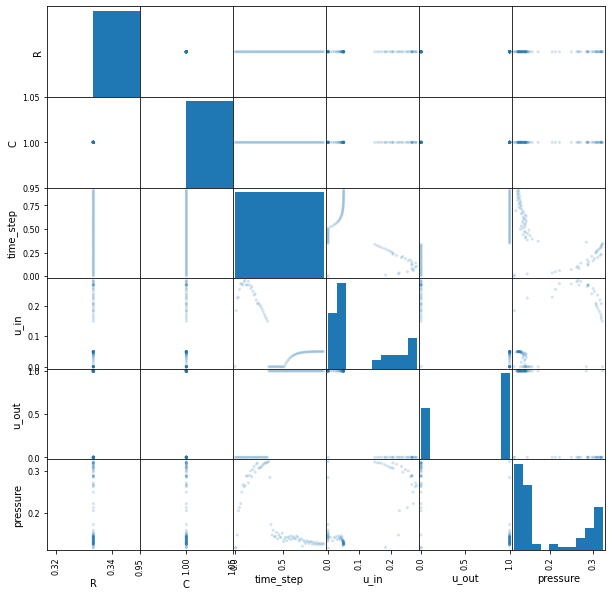

In [17]:
pd.plotting.scatter_matrix(df, alpha=0.2)

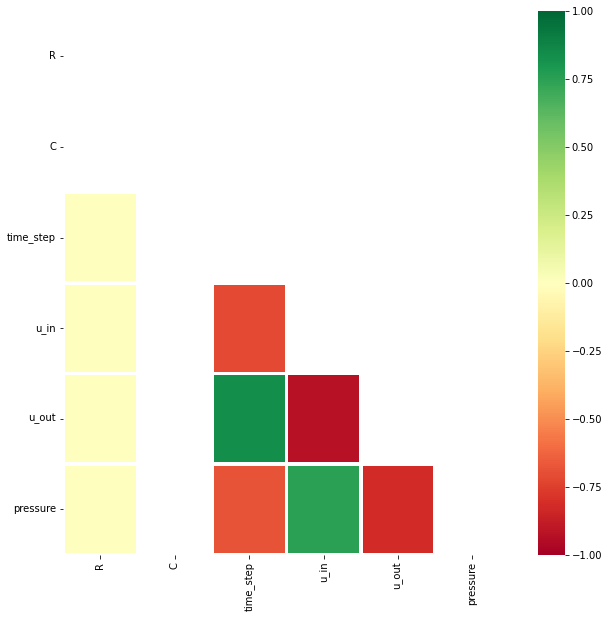

In [18]:
plt.rcParams["figure.figsize"] = (10,10)
corr_df = df.corr()
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
#generate plot
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

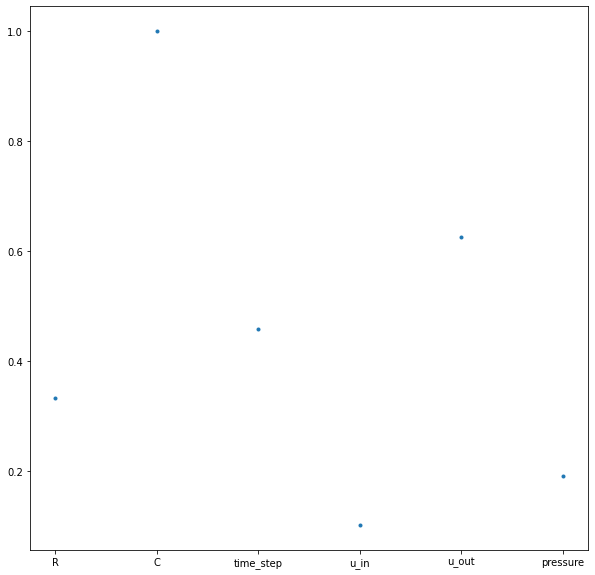

In [19]:
df.mean().plot(style='.')

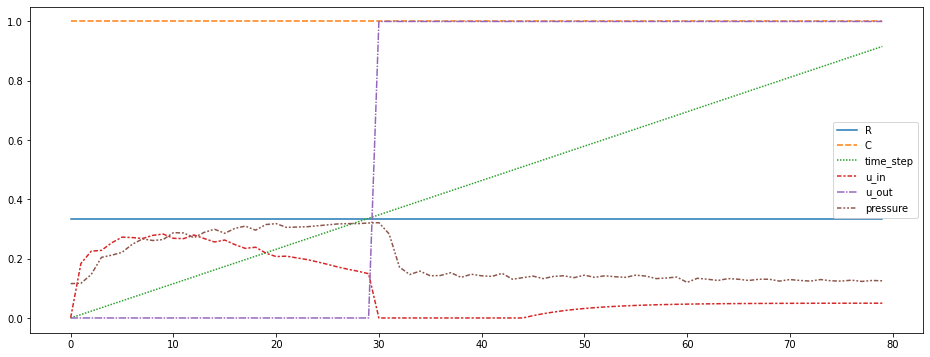

In [20]:
# Set the width and height of the figure
plt.figure(figsize=(16,6))

# Line chart showing
sns.lineplot(data=df)

In [21]:
df['R'].nunique(),df['C'].nunique(),df['u_out'].diff().abs().sum()

(1, 1, 1.0)

In [22]:
#breath_id is not continuous
train['breath_id'].unique()[:81]

array([  1,   2,   3,   4,   5,   6,   7,   9,  10,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,
        30,  32,  34,  35,  36,  37,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  52,  53,  54,  55,  57,  58,  59,  60,  61,  63,
        64,  66,  67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  79,
        82,  83,  84,  87,  89,  90,  92,  93,  94, 100, 101, 104, 106,
       108, 111, 112])

In [23]:
test['breath_id'].unique()[:81]

array([  0,   8,  11,  24,  31,  33,  38,  45,  50,  51,  56,  62,  65,
        74,  78,  80,  81,  85,  86,  88,  91,  95,  96,  97,  98,  99,
       102, 103, 105, 107, 109, 110, 113, 116, 121, 123, 124, 127, 128,
       132, 137, 139, 140, 145, 153, 158, 159, 161, 168, 171, 174, 178,
       180, 182, 185, 194, 195, 196, 198, 200, 205, 206, 209, 210, 215,
       220, 222, 228, 232, 233, 236, 243, 246, 247, 248, 250, 252, 253,
       260, 261, 265])

# From above, we can see R and C are constant, u_out only changes once. Let's confirm it in all train/test data

In [24]:
def count_changes(series):
    return series.diff().abs().sum()

In [25]:
agg = train.groupby('breath_id').agg({'u_out': count_changes}).reset_index(drop=False)

In [26]:
agg.describe()

,breath_id,u_out
count,75450.000000,75450.0
mean,62838.858701,1.0
std,36335.493977,0.0
min,1.000000,1.0
25%,31377.250000,1.0
50%,62765.500000,1.0
75%,94300.750000,1.0
max,125749.000000,1.0


In [27]:
agg = train.groupby('breath_id').agg({'R': [np.mean, np.std], 'C':[np.mean, np.std]}).reset_index(drop=False)
agg.describe()

breath_id             R                      C         
                              mean      std          mean      std
count   75450.000000  75450.000000  75450.0  75450.000000  75450.0
mean    62838.858701     27.036183      0.0     26.080716      0.0
std     36335.493977     19.595619      0.0     17.152426      0.0
min         1.000000      5.000000      0.0     10.000000      0.0
25%     31377.250000      5.000000      0.0     10.000000      0.0
50%     62765.500000     20.000000      0.0     20.000000      0.0
75%     94300.750000     50.000000      0.0     50.000000      0.0
max    125749.000000     50.000000      0.0     50.000000      0.0

In [28]:
agg = test.groupby('breath_id').agg({'u_out': count_changes, 'R': [np.mean, np.std], 'C':[np.mean, np.std]}).reset_index(drop=False)
agg.describe()

breath_id         u_out  ...             C         
                     count_changes  ...          mean      std
count   50300.000000       50300.0  ...  50300.000000  50300.0
mean    62927.961948           1.0  ...     26.070378      0.0
std     36249.599238           0.0  ...     17.171203      0.0
min         0.000000           1.0  ...     10.000000      0.0
25%     31530.500000           1.0  ...     10.000000      0.0
50%     63057.500000           1.0  ...     20.000000      0.0
75%     94333.250000           1.0  ...     50.000000      0.0
max    125748.000000           1.0  ...     50.000000      0.0

[8 rows x 6 columns]

In [29]:
agg = train.groupby('breath_id').agg({'pressure': ['first', 'last', np.mean, np.std]}).reset_index(drop=False)
agg.head()

breath_id  pressure                                
                first      last       mean        std
0         1  5.837492  6.470211  10.841247   5.135058
1         2  6.048398  5.134470   9.334145   4.365212
2         3  5.064168  6.610815  13.534698   8.599539
3         4  6.259305  6.329607  13.914329  10.388633
4         5  6.329607  6.048398   9.666322   4.647055

In [30]:
def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        ret.append('.'.join([prefix] + list(c)))
    return ret

In [31]:
agg.columns = flatten_name('pressure', agg.columns)

In [32]:
agg['last_first_diff'] = (agg['pressure.pressure.first']*0.5-agg['pressure.pressure.last']*0.5).abs()

In [33]:
agg.head()

,pressure.breath_id.,pressure.pressure.first,pressure.pressure.last,pressure.pressure.mean,pressure.pressure.std,last_first_diff
0,1,5.837492,6.470211,10.841247,5.135058,0.316360
1,2,6.048398,5.134470,9.334145,4.365212,0.456964
2,3,5.064168,6.610815,13.534698,8.599539,0.773324
3,4,6.259305,6.329607,13.914329,10.388633,0.035151
4,5,6.329607,6.048398,9.666322,4.647055,0.140604


In [34]:
agg.describe()

,pressure.breath_id.,pressure.pressure.first,pressure.pressure.last,pressure.pressure.mean,pressure.pressure.std,last_first_diff
count,75450.000000,75450.000000,75450.000000,75450.000000,75450.000000,75450.000000
mean,62838.858701,5.810529,6.096131,11.220408,6.519068,0.246662
std,36335.493977,1.015653,0.745234,3.144411,3.753581,0.327004
min,1.000000,-1.825442,-1.825442,-1.739322,0.047052,0.000000
25%,31377.250000,5.485981,5.978096,8.666274,3.493781,0.035151
50%,62765.500000,6.189002,6.259305,10.964276,6.294316,0.105453
75%,94300.750000,6.399909,6.470211,13.415184,9.145174,0.316360
max,125749.000000,7.454441,7.665347,26.883318,25.553560,2.214518


As we can see, the last value of pressure is similar to the first one, the average is higher than the first/last value.

In [35]:
neg_pressure = agg[agg['pressure.pressure.first'] <= 0]
neg_pressure.shape

(67, 6)

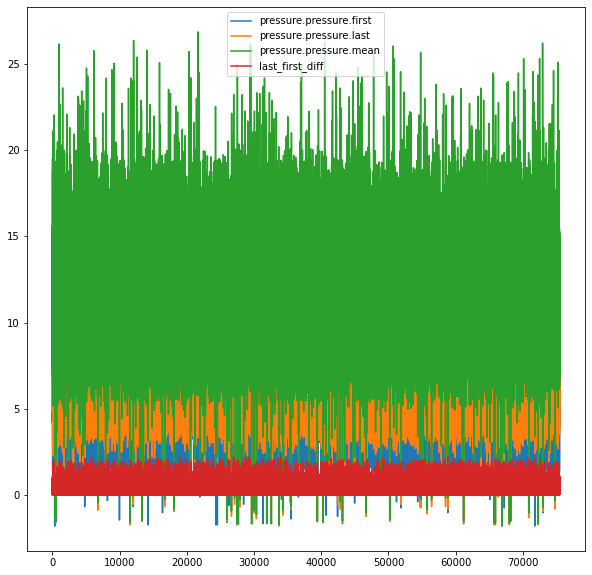

In [36]:
data=agg[['pressure.pressure.first', 'pressure.pressure.last', 'pressure.pressure.mean', 
          'last_first_diff']].plot()

## Split train to batch, change pressure to log change

In [37]:
#found when u_out is changed
def change_index(serial):
    return np.sum(np.abs(serial - serial.iloc[-1]))

In [38]:
%%script echo skipping
#add time serial id
df_train = train.copy()
df_train["time_id"] = train.groupby("breath_id")["time_step"].rank(method="first", ascending=True)


# make pressure not negtive
df_train['pressure.log'] = df_train['pressure']+2


df_train['pressure.log'] = np.log(df_train['pressure.log'])
# df_train.describe()

df_train["pressure.logdiff"] = df_train.groupby("breath_id")["pressure.log"].diff()

df_train["u_in.log1p"] = np.log1p(df_train['u_in'])
# df_train.describe()

df_train["u_in.log1pdiff"] = df_train.groupby("breath_id")["u_in.log1p"].diff()
# df_train.head(81)

pv_train = pd.pivot_table(df_train,index=['breath_id'], columns=df_train.groupby(['breath_id']).cumcount().add(1), 
               values=['u_in', 'u_in.log1p', 'u_in.log1pdiff', 'pressure'])
pv_train.columns=pv_train.columns.map('{0[0]}{0[1]}'.format)

agg = train.groupby('breath_id').agg({'u_out': ['first', 'last', change_index], 'R': np.mean, 'C': np.mean}).reset_index(drop=False)
agg.columns = flatten_name('const', agg.columns)
# agg.head(81)

agg.rename(columns={'const.breath_id.':'breath_id'}, inplace=True)
# agg.head()

pv_train = pd.merge(pv_train, agg, on='breath_id', how='left')
pv_train.head(81)

skipping


In [39]:
#Feature engineering
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
#     df['R'] = df['R'].astype(str)
#     df['C'] = df['C'].astype(str)
#     df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [40]:
train = add_features(train)
test = add_features(test)

In [41]:
train.shape, test.shape

((6036000, 39), (4024000, 38))

In [42]:
def get_feature(train, target=False):
    df_train = train.copy()
#     df_train["u_in.log1p"] = np.log1p(df_train['u_in'])
#     df_train["u_in.log1pdiff"] = df_train.groupby("breath_id")["u_in.log1p"].diff()
    # remove constant features
    value_cols = [col for col in df_train.columns if col not in ['breath_id', 'R', 'C', 'time_step', 'u_out']]

    pv_train = pd.pivot_table(df_train,index=['breath_id'], columns=df_train.groupby(['breath_id']).cumcount().add(1), 
                   values=value_cols)
#     pv_train.columns=pv_train.columns.map('{0[0]}{0[1]}'.format)
    print(pv_train.shape)
    features = {'u_out': ['first', 'last', change_index], 'R': np.mean, 'C': np.mean}
    agg = train.groupby('breath_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('const', agg.columns)
    agg.rename(columns={'const.breath_id.':'breath_id'}, inplace=True)
    pv_train = pd.merge(pv_train, agg, on='breath_id', how='left')
    del df_train
    
    return pv_train

In [43]:
%%time
pv_train = get_feature(train, True)
#pv_train.to_csv('pv_train.csv', index=False)
pv_train.head()

(75450, 2720)


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


CPU times: user 53.7 s, sys: 2.61 s, total: 56.3 s
Wall time: 56 s


In [44]:
import collections
a = pv_train.columns.to_list()
[x for x, y in collections.Counter(a).items() if y > 1]

[]

In [45]:
[col for col in pv_train.columns if 'pressure' in col]

[('pressure', 1),
 ('pressure', 2),
 ('pressure', 3),
 ('pressure', 4),
 ('pressure', 5),
 ('pressure', 6),
 ('pressure', 7),
 ('pressure', 8),
 ('pressure', 9),
 ('pressure', 10),
 ('pressure', 11),
 ('pressure', 12),
 ('pressure', 13),
 ('pressure', 14),
 ('pressure', 15),
 ('pressure', 16),
 ('pressure', 17),
 ('pressure', 18),
 ('pressure', 19),
 ('pressure', 20),
 ('pressure', 21),
 ('pressure', 22),
 ('pressure', 23),
 ('pressure', 24),
 ('pressure', 25),
 ('pressure', 26),
 ('pressure', 27),
 ('pressure', 28),
 ('pressure', 29),
 ('pressure', 30),
 ('pressure', 31),
 ('pressure', 32),
 ('pressure', 33),
 ('pressure', 34),
 ('pressure', 35),
 ('pressure', 36),
 ('pressure', 37),
 ('pressure', 38),
 ('pressure', 39),
 ('pressure', 40),
 ('pressure', 41),
 ('pressure', 42),
 ('pressure', 43),
 ('pressure', 44),
 ('pressure', 45),
 ('pressure', 46),
 ('pressure', 47),
 ('pressure', 48),
 ('pressure', 49),
 ('pressure', 50),
 ('pressure', 51),
 ('pressure', 52),
 ('pressure', 53),
 (

## Get feature for test

In [46]:
pv_test = get_feature(test)
pv_test.head(81)

(50300, 2640)


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,breath_id,"(area, 1)","(area, 2)","(area, 3)","(area, 4)","(area, 5)","(area, 6)","(area, 7)","(area, 8)","(area, 9)","(area, 10)","(area, 11)","(area, 12)","(area, 13)","(area, 14)","(area, 15)","(area, 16)","(area, 17)","(area, 18)","(area, 19)","(area, 20)","(area, 21)","(area, 22)","(area, 23)","(area, 24)","(area, 25)","(area, 26)","(area, 27)","(area, 28)","(area, 29)","(area, 30)","(area, 31)","(area, 32)","(area, 33)","(area, 34)","(area, 35)","(area, 36)","(area, 37)","(area, 38)","(area, 39)",...,"(u_out_lag_back4, 46)","(u_out_lag_back4, 47)","(u_out_lag_back4, 48)","(u_out_lag_back4, 49)","(u_out_lag_back4, 50)","(u_out_lag_back4, 51)","(u_out_lag_back4, 52)","(u_out_lag_back4, 53)","(u_out_lag_back4, 54)","(u_out_lag_back4, 55)","(u_out_lag_back4, 56)","(u_out_lag_back4, 57)","(u_out_lag_back4, 58)","(u_out_lag_back4, 59)","(u_out_lag_back4, 60)","(u_out_lag_back4, 61)","(u_out_lag_back4, 62)","(u_out_lag_back4, 63)","(u_out_lag_back4, 64)","(u_out_lag_back4, 65)","(u_out_lag_back4, 66)","(u_out_lag_back4, 67)","(u_out_lag_back4, 68)","(u_out_lag_back4, 69)","(u_out_lag_back4, 70)","(u_out_lag_back4, 71)","(u_out_lag_back4, 72)","(u_out_lag_back4, 73)","(u_out_lag_back4, 74)","(u_out_lag_back4, 75)","(u_out_lag_back4, 76)","(u_out_lag_back4, 77)","(u_out_lag_back4, 78)","(u_out_lag_back4, 79)","(u_out_lag_back4, 80)",const.u_out.first,const.u_out.last,const.u_out.change_index,const.R.mean,const.C.mean
0,0,0.0,0.239758,1.174935,3.207788,6.567489,11.431896,17.854984,25.834360,35.274422,46.057674,58.004253,71.041916,84.806115,99.207538,114.010960,128.894632,143.584822,157.806386,171.326136,183.784965,194.868342,204.430266,212.241657,218.166515,222.053441,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,223.930798,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,31,5,20
1,8,0.0,0.387993,1.323132,2.272313,4.003997,5.219342,7.664117,8.981660,11.876698,13.155789,16.501289,17.550577,21.117902,22.119035,26.019566,26.750257,30.906878,30.922823,34.734607,35.662131,39.130240,39.950865,43.761771,44.214864,47.905379,48.150176,51.640433,51.640433,55.118947,55.118947,55.118947,55.118947,55.118947,55.118947,55.118947,55.118947,55.118947,55.118947,55.118947,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,29,5,50
2,11,0.0,0.932807,2.339416,3.742459,4.641555,4.833916,5.154979,5.674477,6.416830,7.398961,8.630671,10.096405,11.806569,13.767209,15.937737,18.290210,20.792049,23.432763,26.251420,29.254172,32.429702,35.768663,39.255345,42.872111,46.602555,50.433208,54.361369,58.314836,62.187115,62.187115,62.187115,62.187115,62.187115,62.187115,62.187115,62.187115,62.187115,62.187115,62.187115,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,29,50,10
3,24,0.0,0.107927,0.441064,1.104390,2.171495,3.699291,5.741967,8.318777,11.434905,15.111473,19.333598,24.074784,29.323741,35.061088,41.280995,46.753954,51.316486,54.840987,57.148371,58.487278,61.468140,66.247131,72.876859,81.401347,91.478277,101.572282,111.642783,121.717897,131.752214,141.700329,151.437669,160.826818,170.933077,181.787354,193.320194,205.417665,217.991799,230.937376,244.127904,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,30,50,10
4,31,0.0,1.983169,2.804913,4.211347,10.831482,14.811017,16.026234,26.690897,37.048994,37.048994,52.678472,70.092492,70.092492,80.971544,103.943495,103.943495,115.810382,139.161020,139.161020,152.890860,176.527168,176.527168,190.315653,213.541813,213.541813,226.812738,247.585526,247.585526,262.972740,262.972740,262.972740,262.972740,262.972740,262.972740,262.972740,262

In [47]:
#pv_test.to_csv('pv_test.csv', index=False)

In [48]:
y_features = [col for col in pv_train.columns if 'pressure' in col]
y_target = pv_train[y_features]
y_target.head()

,"(pressure, 1)","(pressure, 2)","(pressure, 3)","(pressure, 4)","(pressure, 5)","(pressure, 6)","(pressure, 7)","(pressure, 8)","(pressure, 9)","(pressure, 10)","(pressure, 11)","(pressure, 12)","(pressure, 13)","(pressure, 14)","(pressure, 15)","(pressure, 16)","(pressure, 17)","(pressure, 18)","(pressure, 19)","(pressure, 20)","(pressure, 21)","(pressure, 22)","(pressure, 23)","(pressure, 24)","(pressure, 25)","(pressure, 26)","(pressure, 27)","(pressure, 28)","(pressure, 29)","(pressure, 30)","(pressure, 31)","(pressure, 32)","(pressure, 33)","(pressure, 34)","(pressure, 35)","(pressure, 36)","(pressure, 37)","(pressure, 38)","(pressure, 39)","(pressure, 40)","(pressure, 41)","(pressure, 42)","(pressure, 43)","(pressure, 44)","(pressure, 45)","(pressure, 46)","(pressure, 47)","(pressure, 48)","(pressure, 49)","(pressure, 50)","(pressure, 51)","(pressure, 52)","(pressure, 53)","(pressure, 54)","(pressure, 55)","(pressure, 56)","(pressure, 57)","(pressure, 58)","(pressure, 59)","(pressure, 60)","(pressure, 61)","(pressure, 62)","(pressure, 63)","(pressure, 64)","(pressure, 65)","(pressure, 66)","(pressure, 67)","(pressure, 68)","(pressure, 69)","(pressure, 70)","(pressure, 71)","(pressure, 72)","(pressure, 73)","(pressure, 74)","(pressure, 75)","(pressure, 76)","(pressure, 77)","(pressure, 78)","(pressure, 79)","(pressure, 80)"
0,5.837492,5.907794,7.876254,11.742872,12.234987,12.867706,14.695562,15.890699,15.539188,15.750094,17.296741,17.226439,16.171907,17.367044,18.070065,17.156137,18.280971,18.773086,17.859159,19.124597,19.335504,18.491878,18.562180,18.632482,18.843389,19.054295,19.265201,19.335504,19.335504,19.476108,19.546410,17.015533,9.563505,7.876254,8.649578,7.595045,7.665347,8.298067,7.243535,7.946556,7.595045,7.454441,8.157463,6.821722,7.173232,7.524743,6.962326,7.454441,7.595045,7.173232,7.735650,7.243535,7.595045,7.384139,7.243535,7.735650,7.524743,6.962326,7.102930,7.313837,6.118700,7.032628,6.821722,6.540513,6.962326,6.821722,6.540513,6.821722,6.821722,6.399909,6.751420,6.540513,6.399909,6.751420,6.470211,6.399909,6.610815,6.329607,6.540513,6.470211
1,6.048398,7.524743,9.282297,10.336829,9.844714,11.180455,11.531965,11.110153,12.375591,12.445893,13.219217,13.219217,13.711332,14.976771,14.344051,15.047073,15.117375,14.695562,15.820396,15.750094,16.382814,16.382814,15.961001,17.085835,16.945231,17.507648,17.367044,18.140367,17.788856,18.562180,17.156137,9.844714,7.876254,8.227765,7.384139,6.751420,7.735650,6.399909,6.399909,7.243535,5.907794,6.610815,6.329607,6.259305,6.821722,5.978096,6.399909,6.610815,6.962326,6.540513,6.821722,6.470211,7.032628,6.189002,7.032628,6.821722,7.032628,6.751420,7.102930,5.696887,6.540513,5.837492,6.259305,5.696887,6.118700,5.626585,5.978096,5.556283,5.696887,5.345377,5.626585,5.134470,5.485981,5.064168,5.204772,5.064168,5.204772,4.993866,5.064168,5.134470
2,5.064168,5.064168,6.751420,12.305289,18.702784,24.537862,27.842063,27.209344,26.365718,25.311186,23.975445,24.116050,25.592395,24.116050,22.850611,22.147589,23.272424,26.436020,27.349948,25.100280,23.202122,22.920913,25.100280,25.803301,23.553632,22.217892,22.780309,25.592395,26.576625,24.537862,22.850611,23.202122,25.592395,23.623935,8.579275,5.134470,7.313837,7.243535,7.173232,7.173232,7.243535,7.032628,6.892024,6.962326,6.821722,7.032628,6.962326,6.892024,7.032628,6.962326,6.681117,7.805952,7.173232,7.524743,7.243535,7.384139,7.805952,6.189002,7.735650,7.665347,7.243535,7.454441,7.384139,8.157463,5.767190,6.962326,7.032628,6.540513,6.962326,6.962326,6.470211,6.540513,6.681117,6.540513,6.329607,6.610815,6.681117,6.048398,6.470211,6.610815
3,6.259305,5.767190,6.540513,8.649578,10.758642,13.359821,16.031303,19.054295,21.444568,24.326956,27.560855,30.724451,33.888048,36.770436,39.301313,40.496449,38.387385,35.856508,33.044422,29.599617,26.014207,22.288194,18.843389,17.437346,18.702784,20.600942,22.217892,23.764539,25.100280,26.084510,26.787531,27.349948,26.646927,21.585172,8.298067,6.048398,6.540513,7.243535,6.540513,6.470211,6.9

# Model

In [49]:
import gc

In [50]:
# del train,test
_= gc.collect()

In [51]:
from numpy.random import seed
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

tf.random.set_seed(42)
from tensorflow import keras
import numpy as nptensorflow
from tensorflow.keras import backend as K

In [52]:
#reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
    gc.collect()

## Baseline

In [53]:
def base_model(feature_num, out_num, hidden_units, dropout_rates):
    print('base_model', feature_num, out_num, hidden_units, dropout_rates)
    
    num_input = keras.Input(shape=(feature_num,), name='num_data')
    input_dense_num = feature_num
    if hidden_units[0] != -1:
        input_dense_num = hidden_units[0]
    
    input_features = keras.layers.Dense(input_dense_num)(num_input)
    
    input_features = keras.layers.BatchNormalization()(input_features)
    input_features = keras.layers.Activation('swish')(input_features)
    if dropout_rates[0] < 1:
        input_features = keras.layers.Dropout(dropout_rates[0])(input_features)

    out = input_features
    
#     # Add one or more hidden layers
    for i in range(1, len(hidden_units)):
        out = keras.layers.Dense(hidden_units[i])(out)
        out = keras.layers.BatchNormalization()(out)
        out = keras.layers.Activation('swish')(out)
        if dropout_rates[i] < 1:
            out = keras.layers.Dropout(dropout_rates[i])(out)

    # A single output: our predicted rating
    out = keras.layers.Dense(out_num, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [num_input],
    outputs = out
    )
    
    model.summary()
    
    return model


In [54]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

def train_and_evaluate_nn_base(train, test, params):
    
    features = [col for col in train.columns if 'pressure' not in col and 'breath_id' not in col ]
    y_features = [col for col in train.columns if 'pressure' in col]
    print(train.shape, test.shape, len(features), len(y_features))
    y = train[y_features]
    
    y_train = np.zeros(y.shape)
    y_test = np.zeros((test.shape[0],y.shape[1]))
    
    print('Check null in train', train[features].isnull().any())
    print('Check null in test', test[features].isnull().any())
    train[features] = train[features].fillna(train[features].mean())
    test[features] = test[features].fillna(train[features].mean())
    print('Check null in test again', test[features].isnull().any())
    
    kf = KFold(n_splits=NFOLD, shuffle=True, random_state=1)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
        print('Fold:', fold)
        x_train, x_val = train.iloc[train_idx], train.iloc[valid_idx]
        y_tra, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        scaler = MinMaxScaler(feature_range=(-1, 1))
        num_data = x_train[features].values
        num_data = scaler.fit_transform(num_data)

        num_data_val = x_val[features].values
        num_data_val = scaler.transform(num_data_val)
        
        model = base_model(len(features), len(y_features), params['hidden_units'], params['dropout_rates'])

        model.compile(
            keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss=keras.losses.MeanAbsoluteError()
        )
        

        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, verbose=0,
            mode='min',restore_best_weights=True)

        plateau = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=7, verbose=0,
            mode='min')

        model.fit([num_data], 
                  y_tra,               
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  validation_data=([num_data_val], y_val),
                  callbacks=[es, 
                            plateau
                            ],
                  validation_batch_size=len(y_val),
                  shuffle=True,
                 verbose = 1)

        pred_val = model.predict([num_data_val]).reshape(1,-1, len(y_features))[0]
        y_train[valid_idx] = pred_val
        test_nn = test[features].values
        test_nn = scaler.transform(test_nn)
        y_test += model.predict([test_nn]).reshape(1,-1, len(y_features))[0]
        
        print(y_train[valid_idx][:3], y_test[:3])
        print('NN base MSE Fold:', mean_absolute_error(y_target.iloc[valid_idx], y_train[valid_idx]))
        
        #Delete model and release GPU memory
        del model, num_data, num_data_val, scaler, test_nn
        gc.collect()
        reset_keras()
    y_test/=NFOLD
    
    return y_train, y_test

In [55]:
import time

nn_base_time = time.time()
NFOLD = 5


params = {
    'batch_size': 4096,
    'epochs': 1000,
    'learning_rate': 0.006,
#     'hidden_units': [128, 128, 64, 32], 1.180226882297499
    'hidden_units': [-1, 
#                      2048, 1024, 
                     512,256,128
                    ],
    'dropout_rates': [0.03527936123679956, 0.32024444956111164,
                     0.2716856145683449,
                     0.4379233941604448] # 1 means no dropout
}

y_nn_train1, y_nn_test1 = train_and_evaluate_nn_base(pv_train, pv_test, params)
_= gc.collect()

print('Check zero in prediction:', (y_nn_train1 == 0).sum())
np.savetxt('pred_nn.csv', y_nn_train1, delimiter=',')

print( 'NN base MSE CV:', mean_absolute_error(y_target, y_nn_train1), 'time: ', int(time.time() - nn_base_time), 's', y_nn_test1[:3])

(75450, 2726) (50300, 2646) 2645 80


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Check null in train (area, 1)                   False
(area, 2)                   False
(area, 3)                   False
(area, 4)                   False
(area, 5)                   False
                            ...  
const.u_out.first           False
const.u_out.last            False
const.u_out.change_index    False
const.R.mean                False
const.C.mean                False
Length: 2645, dtype: bool
Check null in test (area, 1)                   False
(area, 2)                   False
(area, 3)                   False
(area, 4)                   False
(area, 5)                   False
                            ...  
const.u_out.first           False
const.u_out.last            False
const.u_out.change_index    False
const.R.mean                False
const.C.mean                False
Length: 2645, dtype: bool
Check null in test again (area, 1)                   False
(area, 2)                   False
(area, 3)                   False
(area, 4)                   False


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


base_model 2645 80 [-1, 512, 256, 128] [0.03527936123679956, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_data (InputLayer)        [(None, 2645)]            0         
_________________________________________________________________
dense (Dense)                (None, 2645)              6998670   
_________________________________________________________________
batch_normalization (BatchNo (None, 2645)              10580     
_________________________________________________________________
activation (Activation)      (None, 2645)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2645)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1354752   
_____

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[[ 5.65584373  6.80989361  8.70739079 10.21104717 10.89900494 11.7019701
  12.71076107 13.2192421  14.12376022 15.06154251 15.63304043 15.95189762
  16.6630497  17.53527069 18.16239929 18.53544807 19.1588974  20.01182938
  20.71368027 21.06265068 21.67871475 22.46022797 23.02078629 23.34616661
  23.83296776 24.42976379 24.82023239 24.99364662 25.34505081 25.84033585
  24.63646126 16.80523682 13.25737572 12.153162   11.59337997 11.13269997
  10.60930443 10.39005089  9.95439053  9.72561264  9.29587364  9.0398941
   8.67054367  8.38862038  8.08289146  8.01710796  7.68726206  7.62101364
   7.44761276  7.25899649  7.13260698  6.97118759  6.79528856  6.47611618
   6.80439901  6.60894203  6.47634268  6.4515996   6.44248295  6.05876398
   6.17203236  6.0884037   6.00506115  5.89204693  5.86299658  5.73103046
   5.69464827  5.63216496  5.57310009  5.54505491  5.51290464  5.46317577
   5.44107723  5.4287653   5.41685772  5.43104935  5.4237361   5.44319153
   5.45832157  5.46979761]
 [ 5.65353012

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


base_model 2645 80 [-1, 512, 256, 128] [0.03527936123679956, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_data (InputLayer)        [(None, 2645)]            0         
_________________________________________________________________
dense (Dense)                (None, 2645)              6998670   
_________________________________________________________________
batch_normalization (BatchNo (None, 2645)              10580     
_________________________________________________________________
activation (Activation)      (None, 2645)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2645)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1354752   
_____

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[[ 6.31818724  5.61033964  6.53563929  9.74578094 13.84849072 17.64505768
  20.12052155 22.57843971 24.66032982 26.10626984 27.24872398 28.14323616
  28.70933151 28.62626839 28.57201958 28.68219376 28.64260864 28.09957504
  27.27208328 26.78651428 26.4605732  26.01515961 25.46462631 24.88977242
  24.60811234 24.44820595 24.28011703 24.19955063 24.04252052 23.9151001
  23.74124908 23.23847389 21.64500427 13.92687988  8.20850945  6.97181129
   6.99247789  6.75269699  6.60353851  6.47437048  6.3882966   6.28255415
   6.27321148  6.29338646  6.28107309  6.30009174  6.36161566  6.32860088
   6.41983461  6.49884462  6.7308321   6.87455845  6.9193325   6.91720581
   7.10367346  7.08148909  6.83588886  6.6367116   7.23025274  7.06228065
   7.05355597  6.96645832  7.08376122  6.74831629  6.59532833  6.82647419
   6.75533199  6.76325369  6.75863791  6.72644186  6.70924425  6.73153877
   6.72463465  6.70382595  6.69855022  6.66972494  6.69547939  6.63296223
   6.63413191  6.64848614]
 [ 6.2322897

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


base_model 2645 80 [-1, 512, 256, 128] [0.03527936123679956, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_data (InputLayer)        [(None, 2645)]            0         
_________________________________________________________________
dense (Dense)                (None, 2645)              6998670   
_________________________________________________________________
batch_normalization (BatchNo (None, 2645)              10580     
_________________________________________________________________
activation (Activation)      (None, 2645)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2645)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1354752   
_____

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[[ 6.05122709  5.55490112  8.069067   14.56779575 18.86287117 20.82256317
  22.20279312 24.14650917 25.23442841 25.57548714 25.81083298 26.3121109
  26.34077263 26.25028992 26.19028091 26.46811104 26.36389923 25.80181313
  25.818367   26.21803093 26.02127647 25.49186516 25.43458176 25.83431053
  25.86299515 25.49623299 25.41296577 25.70592499 25.88233376 25.63608932
  25.40663719 25.04308319 24.36757088 19.17179298  8.69195938  6.5533905
   7.21859598  7.08907223  7.0466938   7.02480888  6.9516983   6.85869884
   6.90740967  6.8881712   6.81367588  6.82742214  6.82494593  6.7637434
   6.78773975  6.98593903  6.9248333   7.32228804  7.20140266  7.39744043
   7.22911739  7.42156649  7.40294361  6.58831453  7.44109726  7.53168154
   7.28358841  7.27628136  7.33014011  7.22446632  6.51575327  7.00289106
   6.89450359  6.84092236  6.83760309  6.83076334  6.77565002  6.765028
   6.75999546  6.72180271  6.69689751  6.68224335  6.68378925  6.62939167
   6.62600946  6.62222576]
 [ 5.61971617  6

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


base_model 2645 80 [-1, 512, 256, 128] [0.03527936123679956, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_data (InputLayer)        [(None, 2645)]            0         
_________________________________________________________________
dense (Dense)                (None, 2645)              6998670   
_________________________________________________________________
batch_normalization (BatchNo (None, 2645)              10580     
_________________________________________________________________
activation (Activation)      (None, 2645)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2645)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1354752   
_____

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[[ 6.02777576  6.52129269  8.68571854 11.12575722 11.77490997 12.42470646
  13.93887806 14.85271931 15.31395435 15.87375736 16.62134933 16.95568275
  17.16518974 17.43922043 17.89074707 18.12318802 18.19047928 18.38929749
  18.72467613 18.82216835 18.94211769 19.11920929 19.29193306 19.44849586
  19.57603645 19.63605881 19.79026794 19.92121315 20.02404213 20.09582901
  19.37381363 14.79594612 11.16468334  9.39425659  8.41886616  8.14538574
   7.8916502   7.72779989  7.53098774  7.4304533   7.25367069  7.17362022
   7.01886892  6.93959427  6.82156849  6.82728863  6.74844074  6.75014687
   6.79717684  6.80467701  6.90469074  6.93298054  6.88775063  6.76436615
   6.87393618  6.85923433  6.77426481  6.64938164  6.83061314  6.60815334
   6.57217598  6.51615858  6.51536798  6.38748217  6.30753708  6.36848164
   6.3115921   6.28846693  6.26695061  6.22419643  6.21760845  6.20903063
   6.18590879  6.18393612  6.179286    6.16385984  6.17028046  6.16494894
   6.16367579  6.17984056]
 [ 5.363805

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


base_model 2645 80 [-1, 512, 256, 128] [0.03527936123679956, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_data (InputLayer)        [(None, 2645)]            0         
_________________________________________________________________
dense (Dense)                (None, 2645)              6998670   
_________________________________________________________________
batch_normalization (BatchNo (None, 2645)              10580     
_________________________________________________________________
activation (Activation)      (None, 2645)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2645)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1354752   
_____

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[[ 5.88603401  6.49021626  8.37615585 10.02659988 10.25231171 10.46593666
  11.43125725 11.80163288 12.12909222 12.52367878 12.90630341 13.0116148
  13.16313744 13.51416969 13.95808029 14.11141586 14.13143539 14.41613293
  14.95920944 15.12389374 15.24644756 15.42393684 15.67032242 15.96849537
  16.15270042 16.17378807 16.2906971  16.41772079 16.60609627 16.69215965
  15.85859299 10.95308208  8.58419514  7.8922863   7.55619049  7.36701584
   7.11559868  7.00726748  6.81983995  6.75101995  6.59296179  6.55014229
   6.40991306  6.3411355   6.25713062  6.2852335   6.2151618   6.26211214
   6.30555725  6.33682299  6.41825676  6.47950172  6.4324708   6.30047798
   6.48409557  6.43310595  6.40902996  6.28684092  6.43041611  6.18756008
   6.2131443   6.14896202  6.15112448  6.09107065  6.01724195  6.06737328
   6.02390862  6.00231028  5.98497963  5.96169281  5.96358871  5.94786263
   5.94078255  5.94066429  5.93972158  5.92864466  5.93730688  5.94059372
   5.94281578  5.96061707]
 [ 6.0271945

In [56]:
y_pressure = y_nn_test1.reshape((-1))

In [57]:
sample_submission = pd.read_csv(BASE_FOLD + 'sample_submission.csv')

In [58]:
sample_submission.pressure = y_pressure

In [59]:
sample_submission.head()

,id,pressure
0,1,6.180036
1,2,6.619092
2,3,7.629393
3,4,8.161127
4,5,9.546180


In [60]:
sample_submission.to_csv('submission.csv', index=False)

In [61]:
train['pressure.pred'] = y_nn_train1.reshape((-1))

In [62]:
train.head(81)

,breath_id,R,C,time_step,u_in,u_out,pressure,area,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__max,breath_id__u_out__max,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,cross,cross2,pressure.pred
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.083334,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,28.313036,1,0.083334,0.0,0.083334,0.0,28.229702,10.062673,0.083334,0.0,0.083334,0.0,0.000000,0.000000,6.027776
2,1,20,50,0.033652,18.383041,0,5.907794,0.618632,18.466375,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,28.313036,1,18.299707,0.0,18.383041,0.0,9.929994,-8.237035,18.383041,0.0,18.383041,0.0,0.000000,0.000000,6.521293
3,1,20,50,0.067514,22.509278,0,7.876254,2.138333,40.975653,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,0.000000,0.0,27.127486,0.0,28.313036,1,4.126236,0.0,22.425944,0.0,5.803758,-12.363271,22.509278,0.0,22.509278,0.0,0.000000,0.000000,8.685719
4,1,20,50,0.101542,22.808822,0,11.742872,4.454391,63.784476,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,27.127486,0.0,0.000000,0.0,26.807732,0.0,28.313036,1,0.299544,0.0,4.425781,0.0,5.504214,-12.662816,22.725488,0.0,22.808822,0.0,0.000000,0.000000,11.125757
5,1,20,50,0.135756,25.355850,0,12.234987,7.896588,89.140326,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,26.807732,0.0,0.083334,0.0,27.864715,0.0,28.313036,1,2.547028,0.0,2.846573,0.0,2.957185,-15.209844,6.972809,0.0,25.272516,0.0,0.000000,0.000000,11.774910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,20,50,2.587754,4.978481,1,6.610815,598.534439,796.726915,4.974474,1.0,4.981847,1.0,4.969730,1.0,4.984683,1.0,4.964136,1.0,4.987079,1.0,4.957466,1.0,0.000000,0.0,28.313036,1,0.004008,0.0,0.008752,0.0,23.334554,5.167525,0.014346,0.0,0.021016,0.0,4.978481,2.587754,6.170280
78,1,20,50,2.621773,4.981847,1,6.329607,611.595714,801.708762,4.978481,1.0,4.984683,1.0,4.974474,1.0,4.987079,1.0,4.969730,1.0,0.000000,0.0,4.964136,1.0,0.000000,0.0,28.313036,1,0.003366,0.0,0.007374,0.0,23.331188,5.164159,0.012118,0.0,0.017712,0.0,4.981847,2.621773,6.164949
79,1,20,50,2.655746,4.984683,1,6.540513,624.833765,806.693445,4.981847,1.0,4.987079,1.0,4.978481,1.0,0.000000,0.0,4.974474,1.0,0.000000,0.0,4.969730,1.0,0.000000,0.0,28.313036,1,0.002836,0.0,0.006202,0.0,23.328353,5.161323,0.010210,0.0,0.014954,0.0,4.984683,2.655746,6.163676


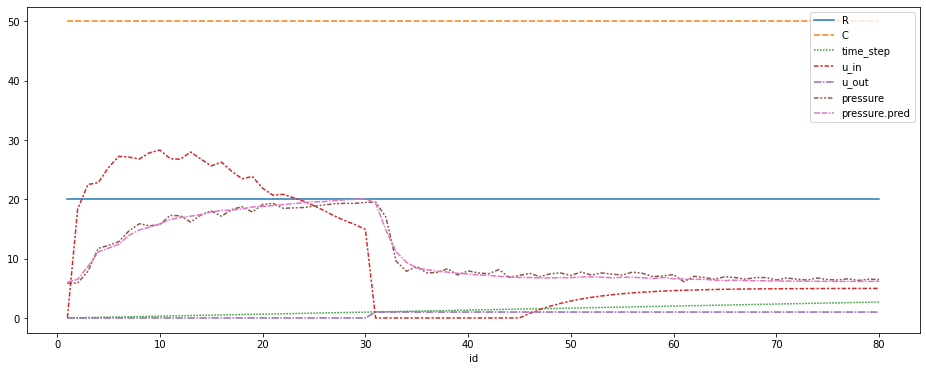

In [63]:
# Set the width and height of the figure
plt.figure(figsize=(16,6))

# Line chart showing
sns.lineplot(data=train.iloc[:80,:][['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure', 'pressure.pred']])

In [64]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>